In [21]:
import nibabel as nib
import numpy as np
import os
import h5py
import time
import json
import pydicom as pdcm
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from glob import glob
from pprint import pprint

root_dir = "/scratch/sangwook/projects/dataset/isles_2018/ISLE2018/ISLES2018_Training/TRAINING/"
save_dir = "/scratch/sangwook/projects/dataset/isles_2018/ISLE2018_H5/"
os.makedirs(save_dir, exist_ok=True)

subject_list = sorted(os.listdir(root_dir))


def plot_with_hist(imgs: list, 
                   img_titles: list, 
                   img_save_path=None) -> None:
    num_imgs = len(imgs)
    fig = plt.figure(figsize=(40, 5 * num_imgs))
    plt.rcParams.update({'font.size': 24})
    axes = dict()
    for img_idx in range(num_imgs):
        if img_idx == (num_imgs - 1):
            cmap='jet'
        else:
            cmap='gray'

        axes[f'ax_{img_idx+1}_image'] = fig.add_subplot(2, num_imgs, img_idx+1)
        im1 = axes[f'ax_{img_idx+1}_image'].imshow(imgs[img_idx], cmap=cmap)

        divider = make_axes_locatable(axes[f'ax_{img_idx+1}_image'])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im1, cax=cax, orientation='vertical')

        axes[f'ax_{img_idx+1}_hist'] = fig.add_subplot(2, num_imgs, img_idx+num_imgs+1)
        im2 = axes[f'ax_{img_idx+1}_hist'].hist(imgs[img_idx].flatten(), bins=50)

        axes[f'ax_{img_idx+1}_image'].set_title(f"{img_titles[img_idx]}")
        axes[f'ax_{img_idx+1}_image'].axis('off')
        axes[f'ax_{img_idx+1}_hist'].set_title(f"{img_titles[img_idx]} Histogram")

    plt.show()
    if img_save_path is not None:
        plt.savefig(img_save_path, bbox_inches='tight', dpi=100)
    plt.close()
    

def get_header_components(nib_obj_header,
                          target_header=["dim", "pixdim", "datatype", "srow_x", "srow_y", "srow_z"]):
    target_header_dict = dict()
    for tg in target_header:
        target_header_dict[tg] = nib_obj_header[tg]
    return target_header_dict


def save_h5(save_path, data:dict):
    '''
        | - subject 1
                |- mod 1
                     |- json
                     |- header (selected)
                     |- image
                |- mod 2
                     |- json
                     |- header (selected)
                     |- image
    '''
    hf = h5py.File(save_path, 'w')
    for subject in data.keys():

        subject_start = time.time()

        if data[subject] is None:
            continue

        subject_group = hf.create_group(subject)
        for mod in data[subject].keys():
            mod_group = subject_group.create_group(f"{mod}")
            for key, value in data[subject][mod].items():
                if type(value) == dict:
                    for sub_key, sub_value in value.items():
                        mod_group.create_dataset(sub_key,
                                                 data=sub_value)
                else:
                    mod_group.create_dataset(key,
                                             data=value,
                                             compression="gzip",
                                             compression_opts=9)  # 9 is the highest compression rate

        print(f"Total time for subject: {subject} - {(time.time()-subject_start * 1000):.4f} ")
    hf.close()
    assert os.path.exists(save_path)


def read_h5(file_path, data):
    pass


if __name__ == "__main__":
    
    h5_dict = {
        x: None for x in subject_list
    }
    os.remove(os.path.join(save_dir, "train.hdf5"))

    for subject in subject_list:
        mod_list = sorted(glob(os.path.join(root_dir, subject, "*", "*.nii")))
        json_list = sorted(glob(os.path.join(root_dir, subject, "*", "*.json")))
        
        h5_dict[subject] = {
            x: None for x in [os.path.basename(x).split('.')[-3] for x in mod_list]
        }
        
        for mod_idx, mod_file in enumerate(mod_list):
            mod_name = os.path.basename(mod_file).split('.')[-3]
            nib_file = nib.load(mod_file)
            nib_arr = nib_file.get_fdata()
            nib_header = get_header_components(nib_file.header)
            
            with open(json_list[mod_idx]) as f:
                nib_json = json.load(f)
            f.close()
                
            h5_dict[subject][mod_name] = dict(
                image=nib_arr,
                header=nib_header,
            )
        break
    
    save_h5(os.path.join(save_dir, "train.hdf5"), h5_dict)


In [23]:
data = h5_dict
os.remove(os.path.join(save_dir, "train.hdf5"))
save_path = os.path.join(save_dir, "train.hdf5")

hf = h5py.File(save_path, 'w')
for subject in data.keys():
    
    subject_start = time.time()

    if data[subject] is None:
        continue

    subject_group = hf.create_group(subject)
    for mod in data[subject].keys():
        mod_group = subject_group.create_group(f"{mod}")
        for key, value in data[subject][mod].items():
            if type(value) == dict:
                for sub_key, sub_value in value.items():
                    mod_group.create_dataset(sub_key,
                                             data=sub_value)
            else:
                mod_group.create_dataset(key,
                                         data=value,
                                         compression="gzip",
                                         compression_opts=9)  # 9 is the highest compression rate
                
    print(f"Total time for subject: {subject} - {(time.time()-subject_start * 1000):.4f} ")
hf.close()

Total time for subject: case_1 - -1636308715405.6267 


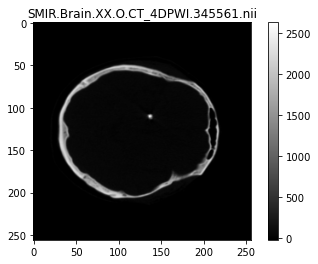

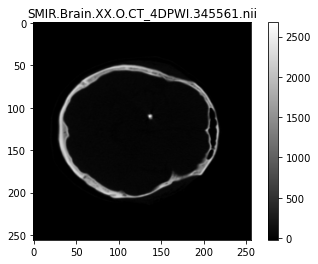

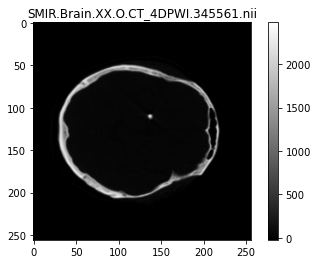

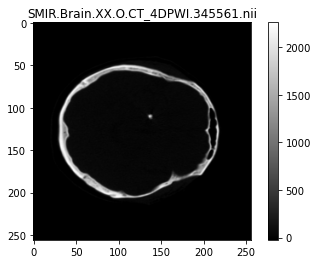

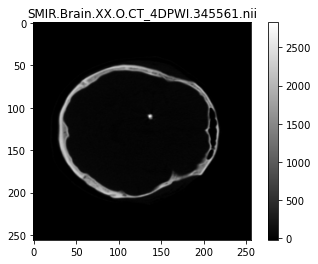

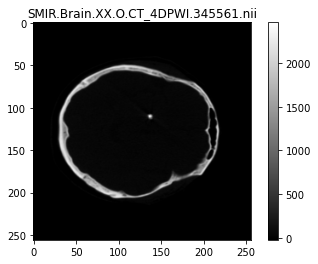

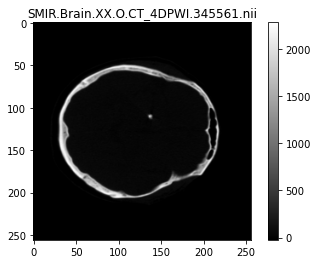

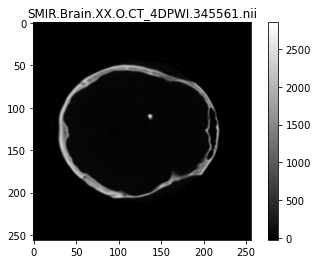

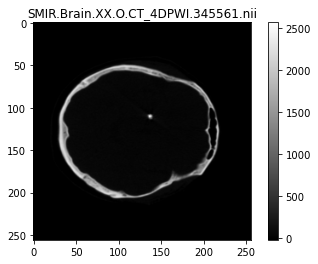

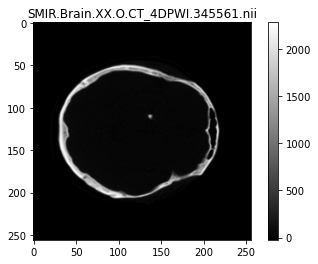

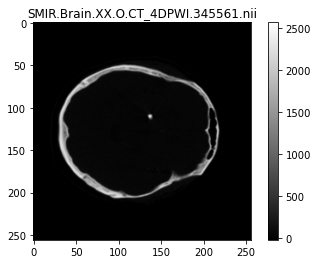

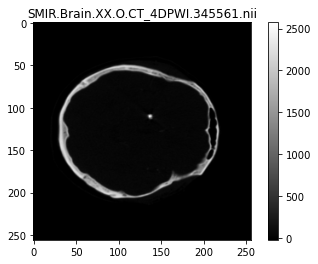

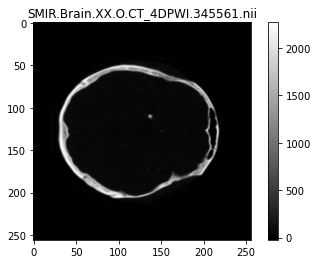

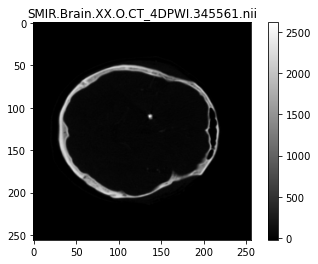

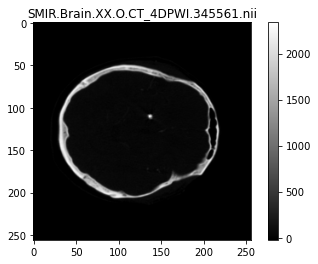

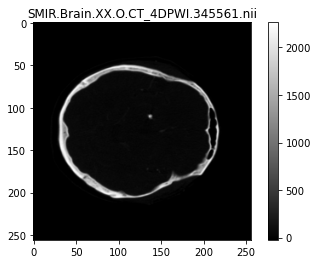

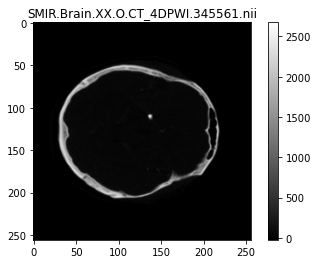

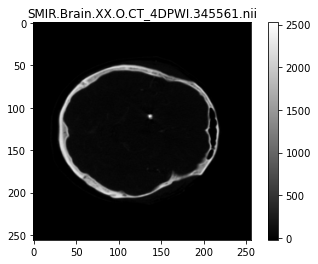

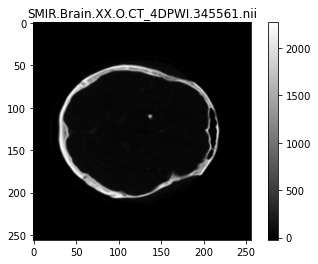

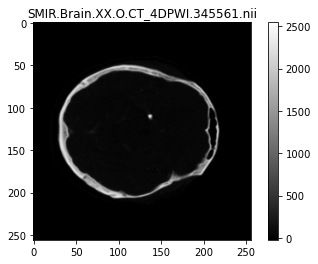

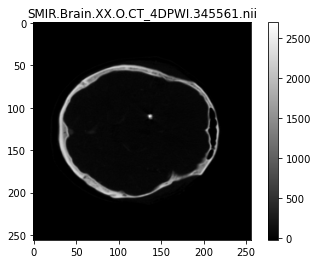

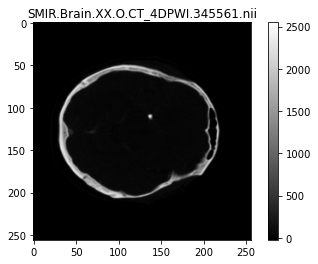

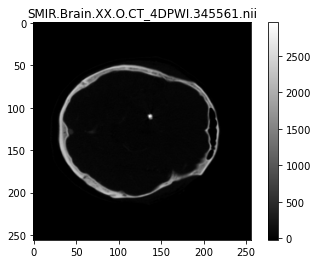

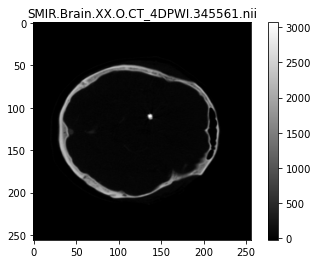

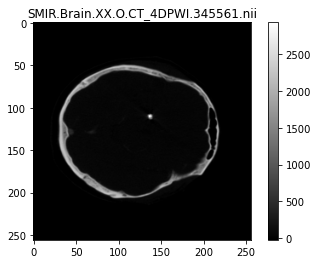

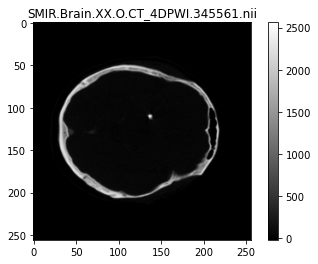

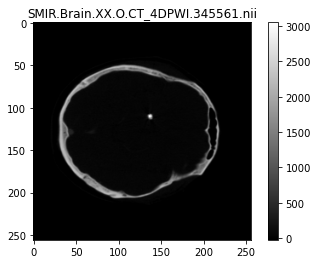

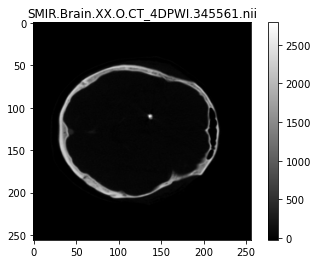

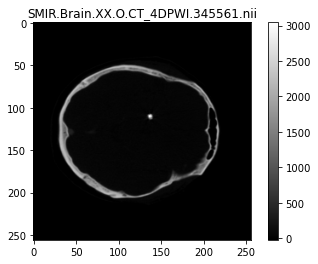

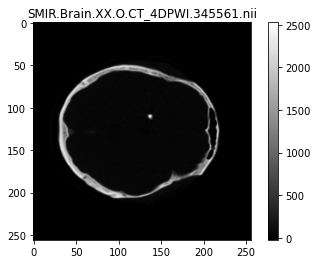

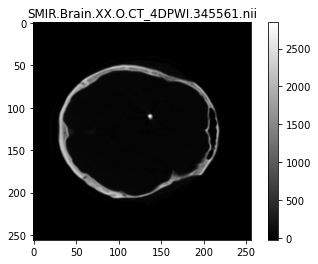

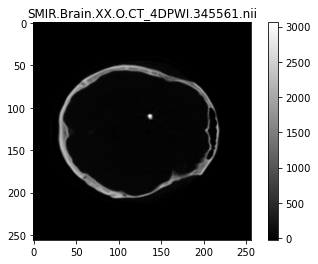

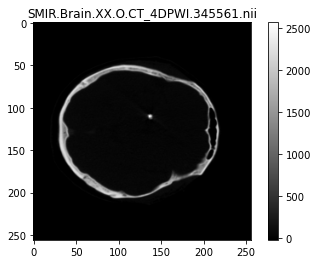

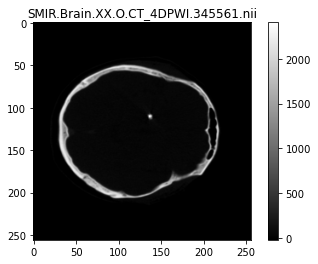

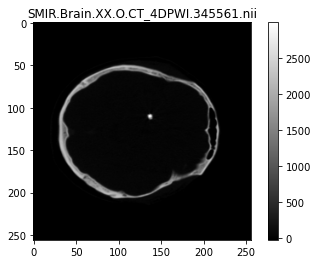

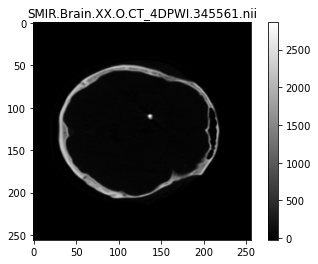

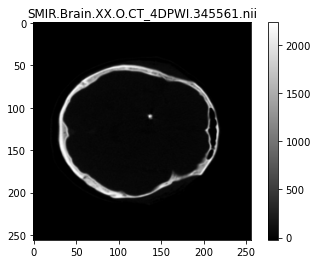

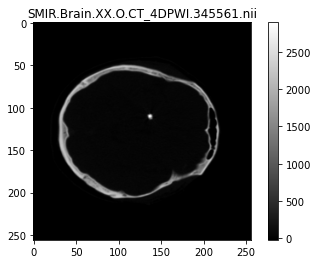

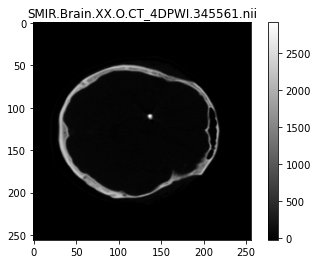

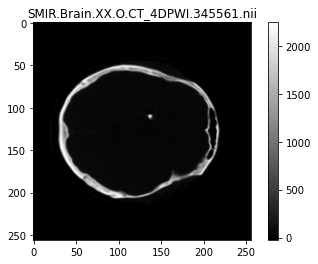

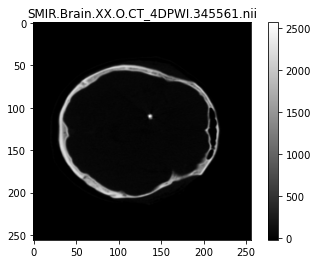

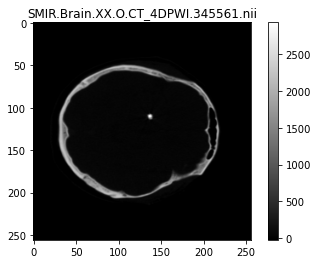

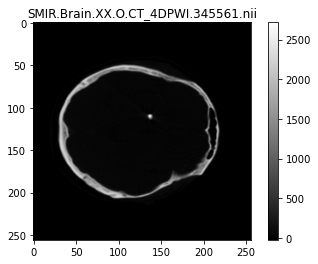

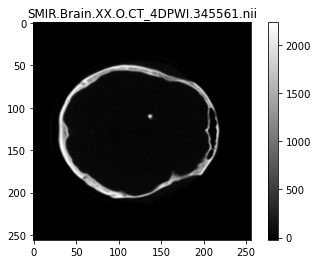

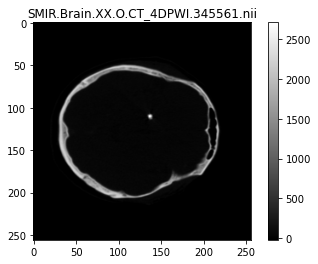

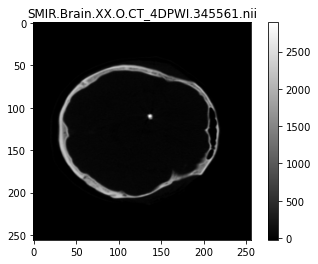

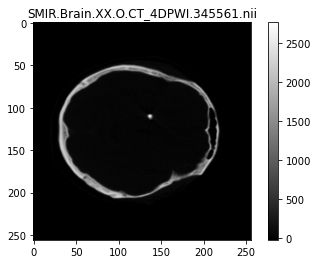

KeyboardInterrupt: 

In [32]:
for i in range(nib_arr.shape[-1]):
    plt.title(mod_name)
    plt.imshow(nib_arr[:, :, 2, i], cmap='gray')
    plt.colorbar()
    plt.show()
    plt.close()